In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)


data_path = './data/train.csv'
if os.path.exists(data_path):
    data = pd.read_csv(data_path)

In [26]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


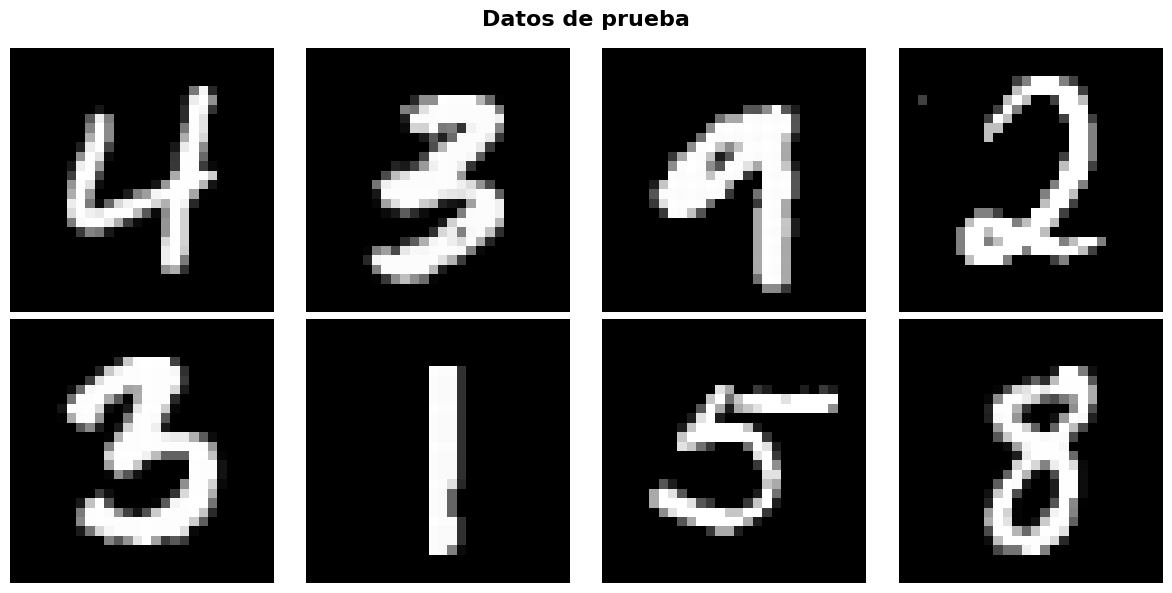

In [27]:
def visualize_samples(data, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Datos de prueba', fontsize=16, fontweight='bold')
    
    sample_indices = np.random.choice(len(data), n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        row, col = i // 4, i % 4
        
        if 'label' in data.columns:
            image = data.iloc[idx, 1:].values.reshape(28, 28)
        else:
            image = data.iloc[idx, 1:].values.reshape(28, 28)
        
        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(data)

In [28]:

data = np.array(data)
m, n = data.shape

np.random.shuffle(data)

dev_size = min(1000, m // 5)
train_size = m - dev_size


data_dev = data[0:dev_size].T
Y_dev = data_dev[0].astype(int)
X_dev = data_dev[1:n]
X_dev = X_dev / 255.0

data_train = data[dev_size:m].T
Y_train = data_train[0].astype(int)
X_train = data_train[1:n]
X_train = X_train / 255.0

_, m_train = X_train.shape
_, m_dev = X_dev.shape


In [29]:
Y_train

array([7, 7, 9, ..., 0, 7, 6], shape=(41000,))

In [30]:

def init_params():
    W1 = np.random.randn(10, 784) * 0.1 
    b1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * 0.1
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_stable)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
def forward_prop(W1, b1, W2, b2, X):
   
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
   
    return Z > 0

def one_hot(Y):
   
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
   
    m = Y.size
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    
    return W1, b1, W2, b2


In [31]:
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def compute_cost(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    
    epsilon = 1e-15
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
    
    cost = -np.sum(one_hot_Y * np.log(A2_clipped)) / m
    return cost

def gradient_descent(X, Y, X_dev, Y_dev, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    
    history = {
        'train_cost': [],
        'train_acc': [],
        'dev_cost': [],
        'dev_acc': []
    }
    
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 50 == 0:
            train_cost = compute_cost(A2, Y)
            train_predictions = get_predictions(A2)
            train_acc = get_accuracy(train_predictions, Y)
            
            _, _, _, A2_dev = forward_prop(W1, b1, W2, b2, X_dev)
            dev_cost = compute_cost(A2_dev, Y_dev)
            dev_predictions = get_predictions(A2_dev)
            dev_acc = get_accuracy(dev_predictions, Y_dev)
            
            history['train_cost'].append(train_cost)
            history['train_acc'].append(train_acc)
            history['dev_cost'].append(dev_cost)
            history['dev_acc'].append(dev_acc)
            
            print(f"Iteración {i:3d} | "
                  f"Train: Cost={train_cost:.4f}, Acc={train_acc:.4f} | "
                  f"Dev: Cost={dev_cost:.4f}, Acc={dev_acc:.4f}")
        
    return W1, b1, W2, b2, history



In [32]:
learning_rate = 0.1
epochs = 500

W1, b1, W2, b2, training_history = gradient_descent(
    X_train, Y_train, 
    X_dev, Y_dev,
    learning_rate, 
    epochs
)


Iteración   0 | Train: Cost=2.3250, Acc=0.1239 | Dev: Cost=2.3141, Acc=0.1350
Iteración  50 | Train: Cost=1.7330, Acc=0.4417 | Dev: Cost=1.7021, Acc=0.4560
Iteración 100 | Train: Cost=1.0268, Acc=0.6953 | Dev: Cost=1.0029, Acc=0.7150
Iteración 150 | Train: Cost=0.7266, Acc=0.7909 | Dev: Cost=0.7169, Acc=0.7940
Iteración 200 | Train: Cost=0.5828, Acc=0.8389 | Dev: Cost=0.5850, Acc=0.8320
Iteración 250 | Train: Cost=0.5030, Acc=0.8601 | Dev: Cost=0.5140, Acc=0.8470
Iteración 300 | Train: Cost=0.4565, Acc=0.8719 | Dev: Cost=0.4732, Acc=0.8530
Iteración 350 | Train: Cost=0.4269, Acc=0.8793 | Dev: Cost=0.4475, Acc=0.8670
Iteración 400 | Train: Cost=0.4065, Acc=0.8847 | Dev: Cost=0.4296, Acc=0.8710
Iteración 450 | Train: Cost=0.3912, Acc=0.8880 | Dev: Cost=0.4161, Acc=0.8710


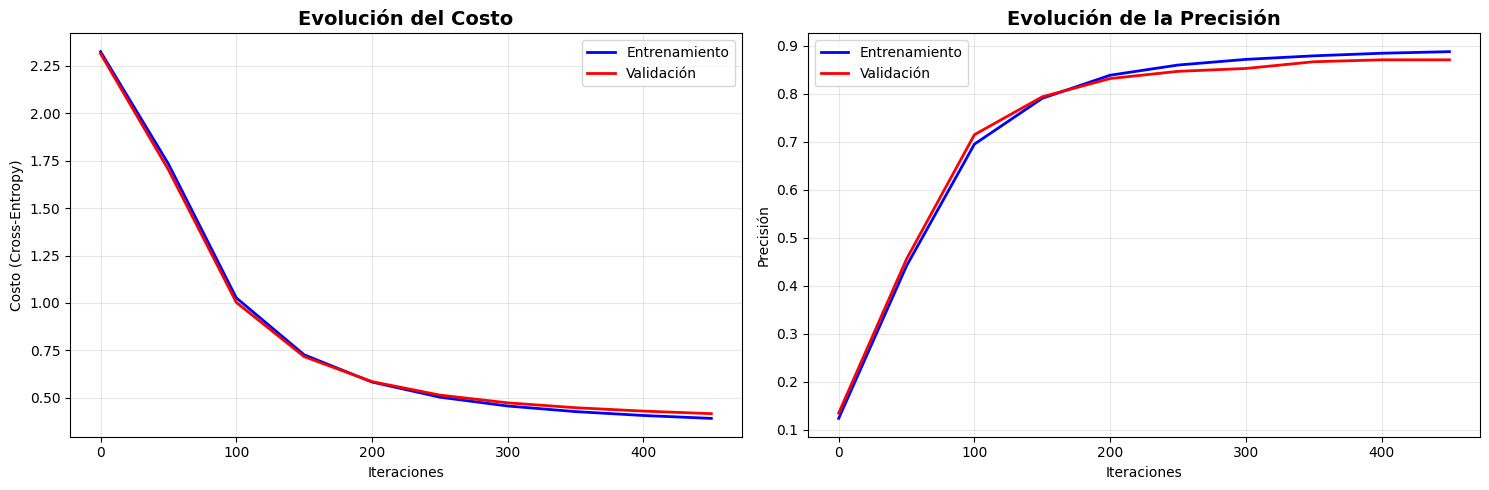

In [33]:

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    iterations = np.arange(0, len(history['train_cost']) * 50, 50)
    
    ax1.plot(iterations, history['train_cost'], 'b-', label='Entrenamiento', linewidth=2)
    ax1.plot(iterations, history['dev_cost'], 'r-', label='Validación', linewidth=2)
    ax1.set_title('Evolución del Costo', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Costo (Cross-Entropy)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(iterations, history['train_acc'], 'b-', label='Entrenamiento', linewidth=2)
    ax2.plot(iterations, history['dev_acc'], 'r-', label='Validación', linewidth=2)
    ax2.set_title('Evolución de la Precisión', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Iteraciones')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

In [34]:

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def get_prediction_probabilities(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return A2

def test_prediction(index, W1, b1, W2, b2, dataset='train'):
    if dataset == 'train':
        X, Y = X_train, Y_train
        dataset_name = "Entrenamiento"
    else:
        X, Y = X_dev, Y_dev
        dataset_name = "Validación"
    
    current_image = X[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2)[0]
    probabilities = get_prediction_probabilities(current_image, W1, b1, W2, b2)
    true_label = Y[index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    image_2d = current_image.reshape((28, 28))
    ax1.imshow(image_2d, cmap='gray')
    ax1.set_title(f'Imagen del conjunto de {dataset_name}', fontweight='bold')
    ax1.axis('off')
    
    digits = np.arange(10)
    bars = ax2.bar(digits, probabilities.flatten(), alpha=0.7)
    
    bars[prediction].set_color('green' if prediction == true_label else 'red')
    if prediction != true_label:
        bars[true_label].set_color('blue')
    
    ax2.set_title('Probabilidades por Dígito', fontweight='bold')
    ax2.set_xlabel('Dígito')
    ax2.set_ylabel('Probabilidad')
    ax2.set_xticks(digits)
    ax2.grid(True, alpha=0.3)
    
    status = "CORRECTO" if prediction == true_label else "❌ INCORRECTO"
    confidence = probabilities[prediction, 0] * 100
    
    print(f"Resultado de la predicción (muestra {index}):")
    print(f"Etiqueta verdadera: {true_label}")
    print(f"Predicción: {prediction}")
    print(f"Confianza: {confidence:.2f}%")
    print(f"Estado: {status}")
    
    if prediction != true_label:
        true_confidence = probabilities[true_label, 0] * 100
        print(f"Confianza en etiqueta verdadera: {true_confidence:.2f}%")
    
    plt.tight_layout()
    plt.show()


Resultado de la predicción (muestra 0):
Etiqueta verdadera: 7
Predicción: 7
Confianza: 97.25%
Estado: CORRECTO


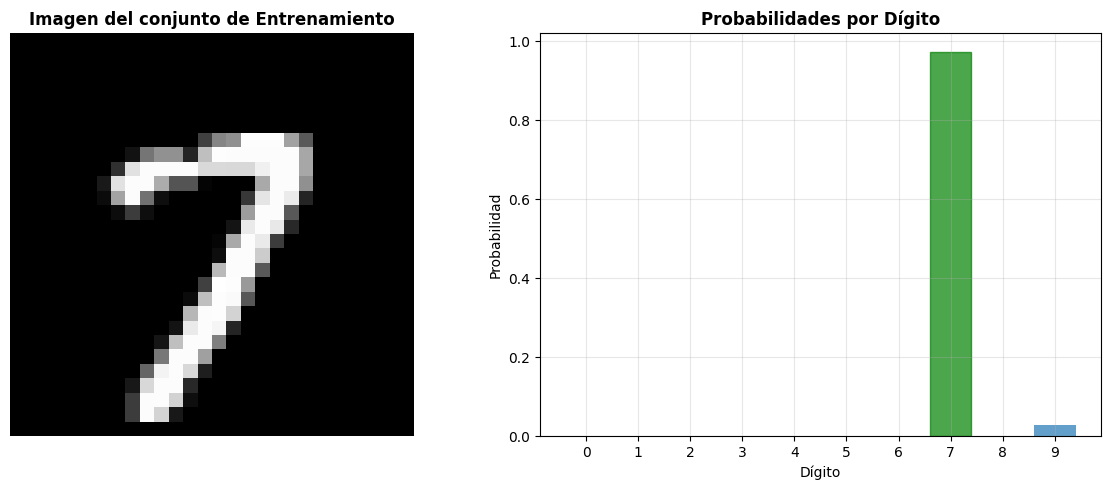


Resultado de la predicción (muestra 1):
Etiqueta verdadera: 7
Predicción: 7
Confianza: 73.55%
Estado: CORRECTO


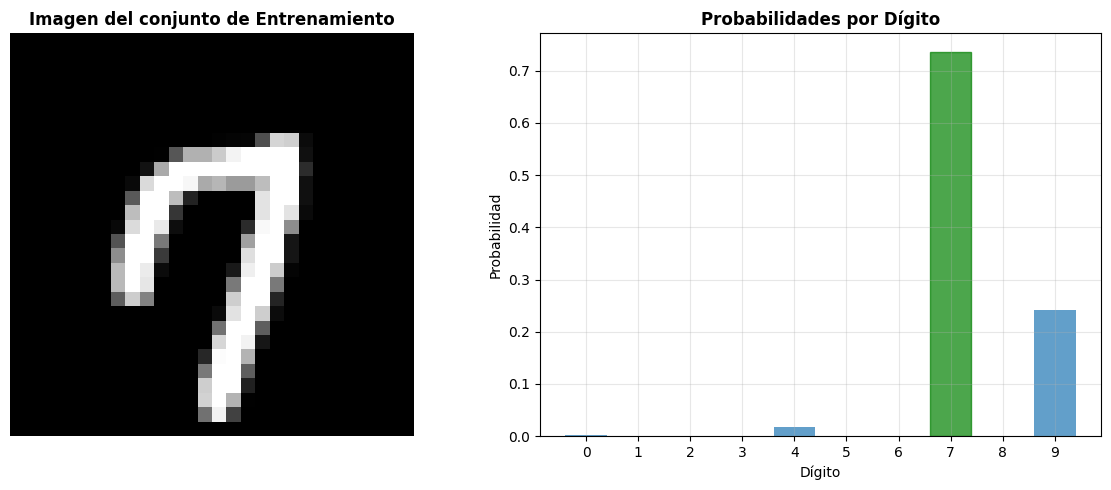


Resultado de la predicción (muestra 2):
Etiqueta verdadera: 9
Predicción: 9
Confianza: 84.87%
Estado: CORRECTO


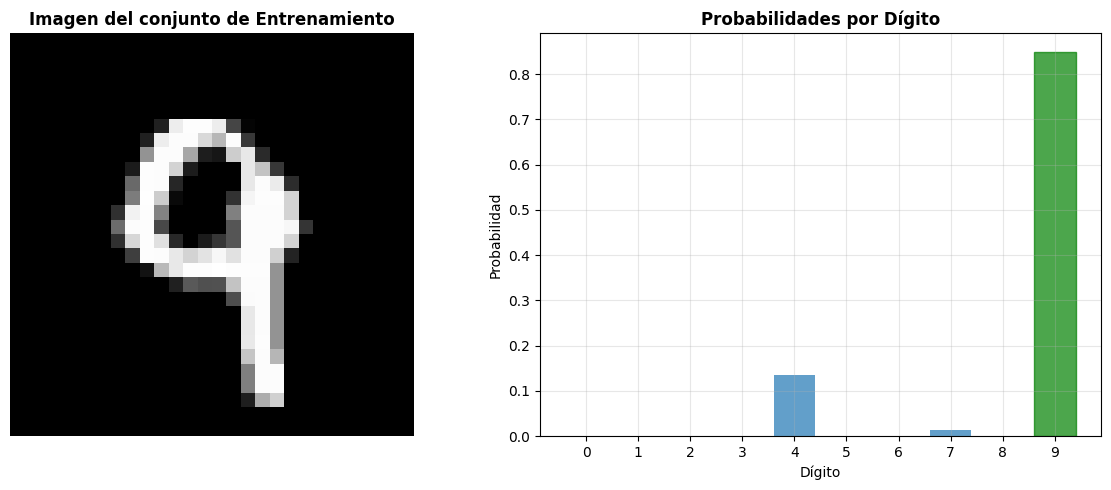


Resultado de la predicción (muestra 0):
Etiqueta verdadera: 1
Predicción: 1
Confianza: 64.16%
Estado: CORRECTO


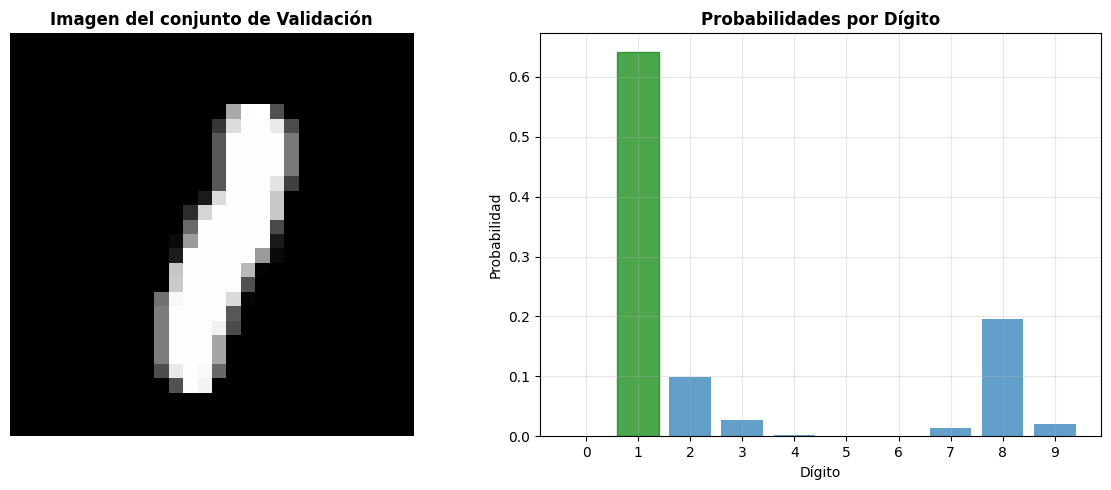


Resultado de la predicción (muestra 1):
Etiqueta verdadera: 5
Predicción: 5
Confianza: 79.58%
Estado: CORRECTO


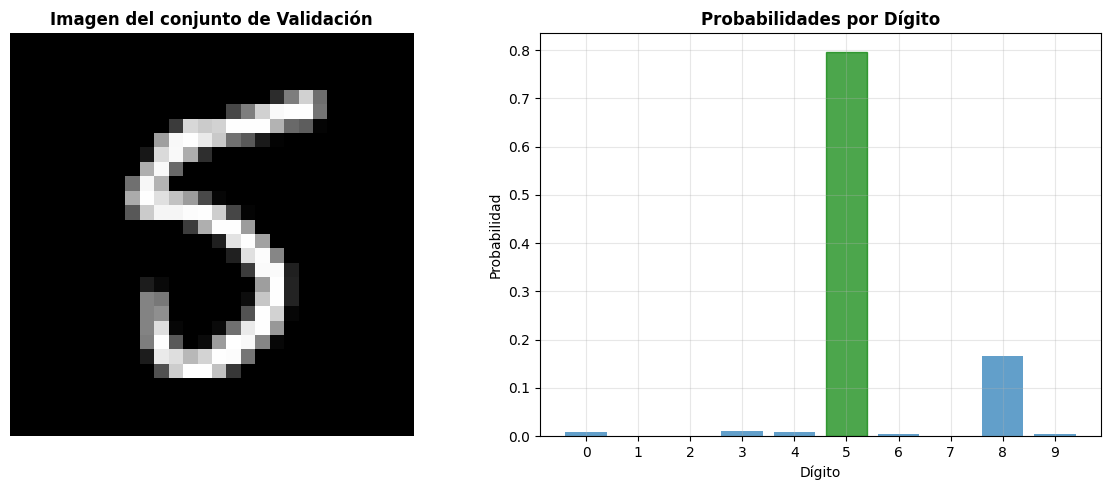


Resultado de la predicción (muestra 2):
Etiqueta verdadera: 0
Predicción: 0
Confianza: 98.11%
Estado: CORRECTO


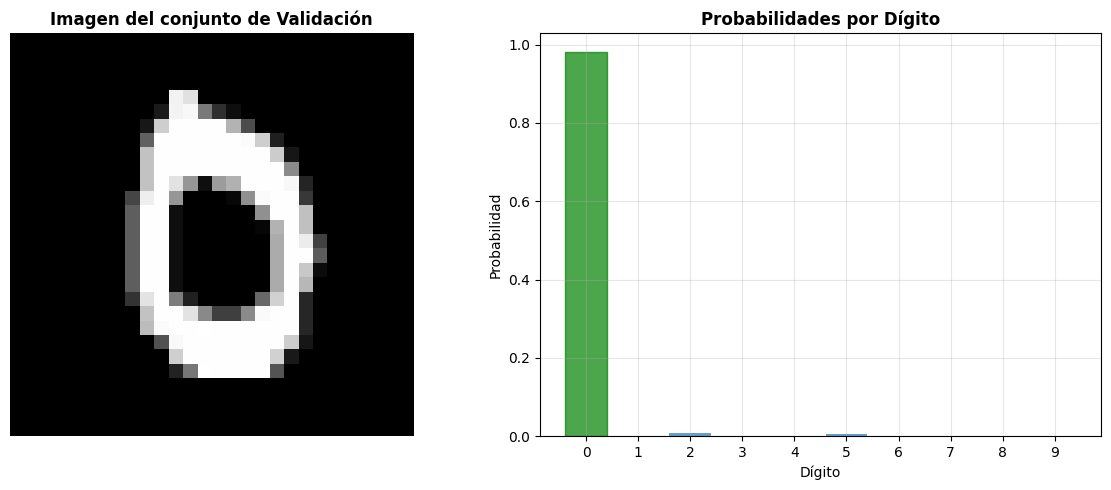

In [35]:

for i in range(3):
    test_prediction(i, W1, b1, W2, b2, dataset='train')
    print()

for i in range(3):
    test_prediction(i, W1, b1, W2, b2, dataset='dev')
    print()

Precisión general: 0.8915 (89.15%)
Costo: 0.3792
Precisión por dígito:
  Dígito 0: 0.956 (3844/4021)
  Dígito 1: 0.971 (4436/4569)
  Dígito 2: 0.858 (3498/4075)
  Dígito 3: 0.867 (3682/4249)
  Dígito 4: 0.898 (3565/3971)
  Dígito 5: 0.808 (3001/3713)
  Dígito 6: 0.929 (3748/4035)
  Dígito 7: 0.898 (3855/4294)
  Dígito 8: 0.851 (3377/3969)
  Dígito 9: 0.864 (3544/4104)


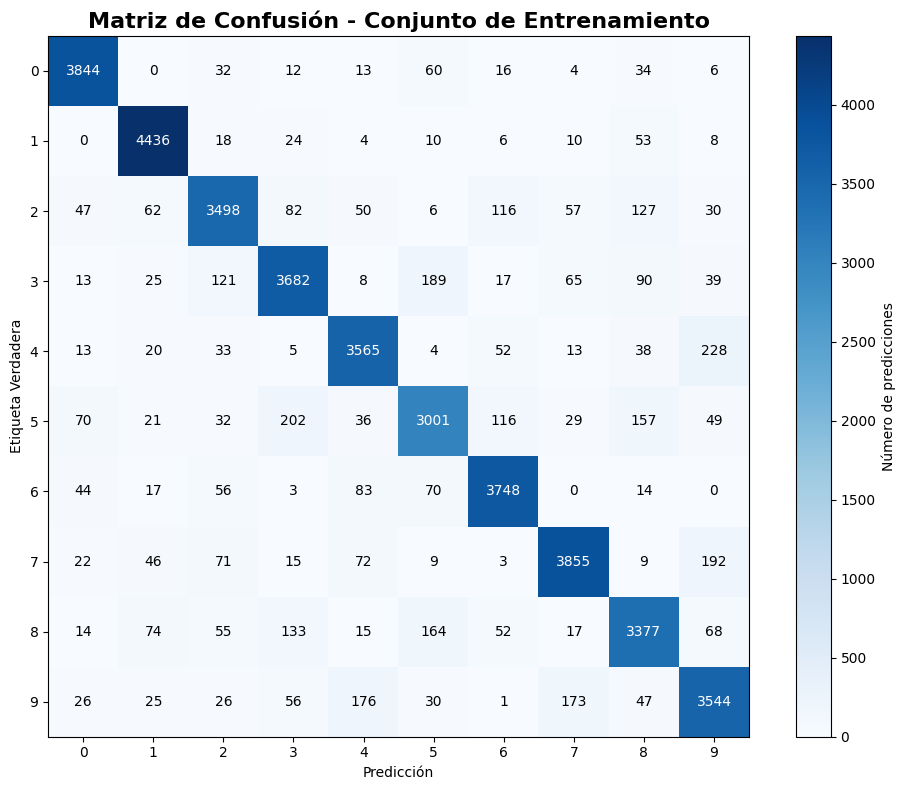


Precisión general: 0.8700 (87.00%)
Costo: 0.4055
Precisión por dígito:
  Dígito 0: 0.946 (105/111)
  Dígito 1: 0.974 (112/115)
  Dígito 2: 0.814 (83/102)
  Dígito 3: 0.843 (86/102)
  Dígito 4: 0.901 (91/101)
  Dígito 5: 0.805 (66/82)
  Dígito 6: 0.902 (92/102)
  Dígito 7: 0.897 (96/107)
  Dígito 8: 0.734 (69/94)
  Dígito 9: 0.833 (70/84)


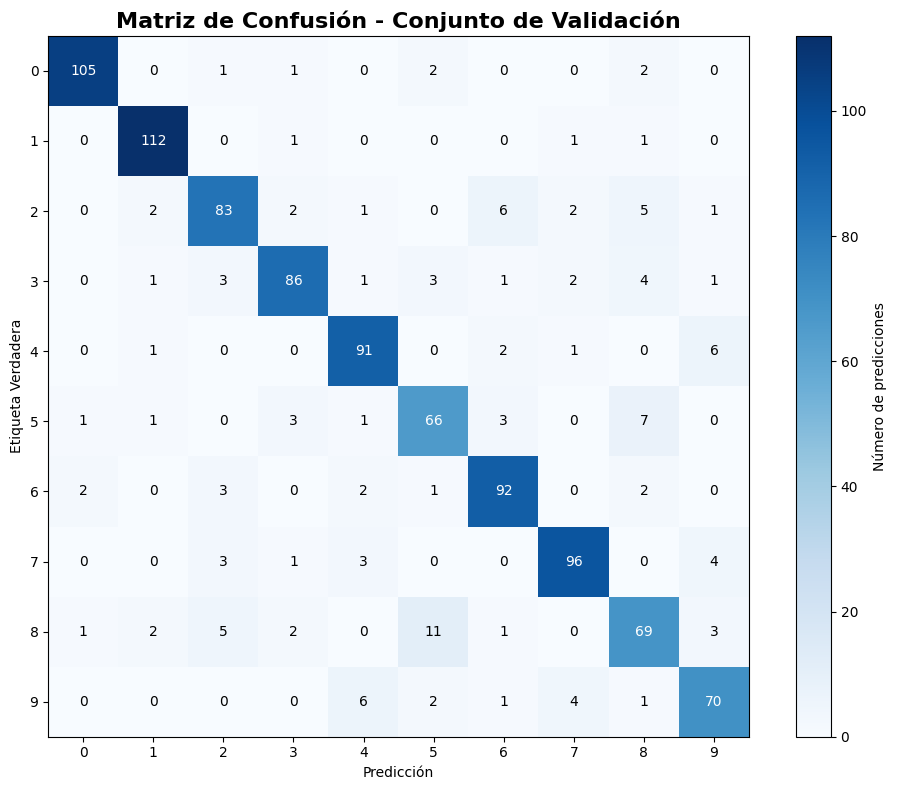

In [36]:
def evaluate_model_performance(X, Y, W1, b1, W2, b2, dataset_name=""):
    
    predictions = make_predictions(X, W1, b1, W2, b2)
    probabilities = get_prediction_probabilities(X, W1, b1, W2, b2)
    
    accuracy = get_accuracy(predictions, Y)
    cost = compute_cost(probabilities, Y)
    
    print(f"Precisión general: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Costo: {cost:.4f}")
    
    confusion_matrix = np.zeros((10, 10))
    for true_label, pred_label in zip(Y, predictions):
        confusion_matrix[true_label, pred_label] += 1
    
    print(f"Precisión por dígito:")
    for digit in range(10):
        correct = confusion_matrix[digit, digit]
        total = np.sum(confusion_matrix[digit, :])
        if total > 0:
            digit_accuracy = correct / total
            print(f"  Dígito {digit}: {digit_accuracy:.3f} ({correct:.0f}/{total:.0f})")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
    plt.title(f'Matriz de Confusión - {dataset_name}', fontsize=16, fontweight='bold')
    plt.colorbar(label='Número de predicciones')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    
    for i in range(10):
        for j in range(10):
            plt.text(j, i, f'{confusion_matrix[i, j]:.0f}', 
                    ha='center', va='center', 
                    color='white' if confusion_matrix[i, j] > confusion_matrix.max()/2 else 'black')
    
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()
    
    return accuracy, confusion_matrix

train_accuracy, train_confusion = evaluate_model_performance(
    X_train, Y_train, W1, b1, W2, b2, "Conjunto de Entrenamiento"
)

print()

dev_accuracy, dev_confusion = evaluate_model_performance(
    X_dev, Y_dev, W1, b1, W2, b2, "Conjunto de Validación"
)